In [1168]:
import sys
from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from autograd.scipy.stats import multivariate_normal
import numpy
import math
import pdb
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [1169]:
plt.rcParams.update({'font.size': 22})

In [1048]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'][0] + architecture['width'][0])
                  + (architecture['output_dim'] * architecture['width'][-1] + architecture['output_dim'])
                  + sum([architecture['width'][i] * architecture['width'][i+1] + architecture['width'][i+1] for i in range(self.params['L'] - 1)])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D
        
        x = x.reshape(-1, 1)

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H[0] * D_in].T.reshape((-1, H[0], D_in))
        b = weights[H[0] * D_in:H[0] * D_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.h(np.matmul(W, x) + b)
        index = H[0] * D_in + H[0]

        assert input.shape[1] == H[0]

        #additional hidden layers
        for i in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H[i+1] * H[i]].T.reshape((-1, H[i+1], H[i]))
            index += H[i] * H[i+1]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H[i+1]

        #output layer
        W = weights[index:index + H[-1] * D_out].T.reshape((-1, D_out, H[-1]))
        b = weights[index + H[-1] * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output


In [1260]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

latent_dim = 2

###neural network model design choices
encoder_width = [4, 2]
encoder_hidden_layers = len(encoder_width)
input_dim = 3

encoder_architecture = {'width': encoder_width,
                        'hidden_layers': encoder_hidden_layers,
                        'input_dim': input_dim,
                        'output_dim': latent_dim * 2,
                        'activation_fn_type': 'relu',
                        'activation_fn_params': 'rate=1',
                        'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
encoder = Feedforward(encoder_architecture, random=random)

decoder_width = [10, 6, 4]
decoder_hidden_layers = len(decoder_width)
output_dim = input_dim

decoder_architecture = {'width': decoder_width,
                        'hidden_layers': decoder_hidden_layers,
                        'input_dim': latent_dim,
                        'output_dim': output_dim,
                        'activation_fn_type': 'relu',
                        'activation_fn_params': 'rate=1',
                        'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
decoder = Feedforward(decoder_architecture, random=random)

In [1261]:
np.random.seed(207)
mean = np.array([1, 2, 3])
# cov = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])
cov = np.eye(len(mean))
X_data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
X_validation = np.random.multivariate_normal(mean=mean, cov=cov, size=100)

In [1262]:
class VAE:
    
    def __init__(self, encoder, decoder, X_data, X_validation, learning_rate=0.01, batch_fraction=0.1, 
                 samples_per_observation=10, set_seed=True, tol_per_param=0.002, all_weights=None, 
                 max_epochs=10, min_epochs=1, max_change=0.05):
        if set_seed:
            np.random.seed(207)
        self.encoder = encoder
        self.decoder = decoder
        self.output_log_variance = np.array([0.0])
        if all_weights is not None:
            self.all_weights = all_weights
        else:
            self.all_weights = np.concatenate([self.encoder.weights.flatten(), self.decoder.weights.flatten(), 
                                               self.output_log_variance])
        self.encoder_weights = self.all_weights[:self.encoder.D].reshape(1, -1)
        self.decoder_weights = self.all_weights[self.encoder.D: -1].reshape(1, -1)
        self.output_log_variance = self.all_weights[-1]
        self.num_weights = len(self.all_weights)
        self.X_data = X_data
        self.X_validation = X_validation
        self.latent_dimension = int(self.encoder.params['D_out'] / 2)
        self.learning_rate = learning_rate
        self.batch_fraction = batch_fraction
        self.samples_per_observation = samples_per_observation
        self.elbo_grad = grad(self.calculate_elbo)
        self.tol = tol_per_param * self.num_weights
        self.max_epochs = max_epochs
        self.min_epochs = min_epochs
        self.max_change = max_change
        
#     def get_latent_mean_and_cov(self, latent_params, min_var=0.01, max_var=1000.):
#         latent_mean = latent_params[:self.latent_dimension]
#         latent_vars = np.maximum(np.minimum(np.exp(latent_params[self.latent_dimension:]), max_var), min_var)
#         latent_cov = latent_vars * np.eye(self.latent_dimension)
#         return latent_mean, latent_cov

    def get_latent_mean_and_cov(self, latent_params, min_var=0.01, max_var=1000.):
        latent_mean = latent_params[:,:self.latent_dimension]
        # latent_vars = np.maximum(np.minimum(np.exp(latent_params[self.latent_dimension:]), max_var), min_var)
        latent_logstd = latent_params[:,self.latent_dimension:]
        # latent_cov = latent_vars * np.eye(len(latent_vars))
        
        return latent_mean, latent_logstd
        
#     def sample_latent_variable(self, latent_mean, latent_cov):
#         eps = np.random.multivariate_normal(mean=np.zeros(self.latent_dimension),
#                                             cov=np.eye(self.latent_dimension), 
#                                             size=1)
#         z_n = eps @ np.sqrt(latent_cov) + latent_mean
#         return z_n
    
    def sample_latent_variable(self, latent_mean, latent_logstd):
        return np.random.randn(*latent_mean.shape) * np.exp(latent_logstd) + latent_mean
        # eps = np.random.multivariate_normal(mean=np.zeros(self.latent_dimension),
        #                                     cov=np.eye(self.latent_dimension), 
        #                                     size=1)
        # z_n = eps @ np.sqrt(latent_cov) + latent_mean
        # return z_n
    
    def diag_gaussian_log_density(self, x, mu, latent_logstd):
        return np.sum(sp.stats.norm.logpdf(x, mu, np.exp(latent_logstd)), axis=-1)
    
    def calculate_elbo(self, all_weights, X):
        encoder_weights = all_weights[:self.encoder.D].reshape(1, -1)
        decoder_weights = all_weights[self.encoder.D: -1].reshape(1, -1)
        output_log_variance = all_weights[-1]
        output_variance = np.exp(output_log_variance)
        
        latent_params = self.encoder.forward(encoder_weights, X)[0].reshape(-1, self.latent_dimension*2)

        latent_mean, latent_logstd = self.get_latent_mean_and_cov(latent_params)
        
        z_n = self.sample_latent_variable(latent_mean, latent_logstd)
        
        log_prior = self.diag_gaussian_log_density(z_n, 0, 0)
        
        output_mean = self.decoder.forward(decoder_weights, z_n)[0].reshape(*X.shape)
        
        log_likelihood = self.diag_gaussian_log_density(X, output_mean, output_log_variance)
        
        log_denom = self.diag_gaussian_log_density(z_n, latent_mean, latent_logstd)
        lower_bound = log_prior + log_likelihood - log_denom
        
        return -lower_bound
        
#     def calculate_elbo(self, all_weights, X):
#         encoder_weights = all_weights[:self.encoder.D].reshape(1, -1)
#         decoder_weights = all_weights[self.encoder.D: -1].reshape(1, -1)
#         output_log_variance = all_weights[-1]
#         output_variance = np.exp(output_log_variance)
        
#         latent_params = self.encoder.forward(encoder_weights, X).flatten()

#         latent_mean, latent_cov = self.get_latent_mean_and_cov(latent_params)
        
#         z_n = self.sample_latent_variable(latent_mean, latent_cov).flatten()
        
#         log_prior = sp.stats.multivariate_normal.logpdf(z_n, np.zeros(len(z_n)), np.eye(len(z_n)))
        
#         output_mean = self.decoder.forward(decoder_weights, z_n).flatten()
        
#         log_likelihood = sp.stats.multivariate_normal.logpdf(X.flatten(), output_mean, 
#                                                              output_variance * np.eye(len(X)))
        
#         log_denom = sp.stats.multivariate_normal.logpdf(z_n, latent_mean, latent_cov)
#         lower_bound = log_prior + log_likelihood - log_denom
        
#         return -lower_bound
    
    def fit(self):
        batch_size = int(len(self.X_data) * self.batch_fraction)
        batches_per_epoch = int(len(self.X_data) / batch_size)
        X_data = self.X_data
        # t_cnt = 0
        # t0 = time.perf_counter()
        
        for epoch in range(self.max_epochs):
            np.random.shuffle(X_data)
            for j in range(batches_per_epoch):
                all_grad_matrix = np.zeros((batch_size, self.num_weights))
                X_minibatch = X_data[j * batch_size: (j + 1) * batch_size]
                for k in range(batch_size):
                    X = X_minibatch[k, :]
                    grad_matrix = np.zeros((self.samples_per_observation, self.num_weights))
                    for l in range(self.samples_per_observation):
                        # t1 = time.perf_counter()
                        elbo_grad = self.elbo_grad(self.all_weights, X)
                        # print(elbo_grad[:self.encoder.D])
                        # t_cnt += time.perf_counter() - t1
                        grad_matrix[l, :] = elbo_grad
                    mean_grad = np.mean(grad_matrix, axis=0)
                    all_grad_matrix[k, :] = mean_grad
                    
                average_grad = np.mean(all_grad_matrix, axis=0)
                
                # print(average_grad)
                
                self.all_weights -= np.maximum(np.minimum(self.learning_rate * average_grad, self.max_change),
                                               -self.max_change)
                
                grad_norm = np.linalg.norm(average_grad)
                print('grad norm:', grad_norm)
                #print('mutual info:', self.calculate_mutual_information())
                print()
                if grad_norm < self.tol and epoch >= self.min_epochs:
                    # print(t_cnt)
                    # print(time.perf_counter() - t0)
                    return 
                
    def generate_synthetic_data(self, n):
        output_dim = self.decoder.params['D_out']
        synthetic_data = np.zeros((n, output_dim))
        # decoder_weights = self.all_weights[self.encoder.D: -1].reshape(1, -1) 
        output_variance = np.exp(self.all_weights[-1])
        for i in range(n): 
            z_n = self.sample_latent_variable(np.zeros(self.latent_dimension),np.zeros(self.latent_dimension))
            z_n = z_n.reshape(1,-1)
            output_mean = self.decoder.forward(self.decoder_weights, z_n)[0].reshape(1,output_dim)
            output_noise = np.random.multivariate_normal(mean=np.zeros(output_dim), 
                                                         cov=output_variance * np.eye(output_dim), 
                                                         size=1)
            
            synthetic_data[i, :] = output_mean.flatten() + output_noise.flatten()
        return synthetic_data
                
#     def generate_synthetic_data(self, n):
#         output_dim = self.decoder.params['D_out']
#         synthetic_data = np.zeros((n, output_dim))
#         # decoder_weights = self.all_weights[self.encoder.D: -1].reshape(1, -1) 
#         output_variance = np.exp(self.all_weights[-1])
#         for i in range(n):
#             z_n = np.random.multivariate_normal(mean=np.zeros(self.latent_dimension), 
#                                                 cov=np.eye(self.latent_dimension), size=1)
#             output_mean = self.decoder.forward(self.decoder_weights, z_n.reshape(-1, 1))
#             output_noise = np.random.multivariate_normal(mean=np.zeros(output_dim),
#                                                             cov=output_variance * np.eye(output_dim),
#                                                             size=1)
#            
#             synthetic_data[i, :] = output_mean.flatten() + output_noise.flatten()
#         return synthetic_data
    
    def sample_latent_space(self, frac=1.0):
        n_samples = int(len(self.X_validation) * frac)
        synthetic_latent_variables = np.zeros((n_samples, self.latent_dimension))
        X_samples = self.X_validation[np.random.choice(len(self.X_validation), n_samples, replace=False)]
        
        for i in range(n_samples):
            X_valid = X_samples[i, :].reshape(-1, 1)
            latent_params = self.encoder.forward(self.encoder_weights, X_valid).flatten()
            z_n = self.sample_latent_variable(latent_params)
            synthetic_latent_variables[i, :] = z_n
        
        return synthetic_latent_variables
        
    def create_latent_plot(self, n=100, max_z=10, stride=0.01):
        if self.decoder.params['D_in'] != 1:
            raise ValueError('latent dimension must be equal to 1')
        X_samples = self.X_data[np.random.choice(len(self.X_data), size=n, replace=False)]
        z_points = np.linspace(-max_z, max_z, int((2 * max_z / stride) + 1))
        output_variance = np.exp(self.all_weights[-1])
        p = Pool()
        approx_mu_lst = []
        true_mu_lst = []
        for i in range(n):
            if i % 10 == 0:
                print(i)
            X = X_samples[i, :]
            approx_mu = self.encoder.forward(self.encoder_weights, X).flatten()[0]
            approx_mu_lst.append(approx_mu)
            
            reimann_points = []
            for z in z_points:
                prior = sp.stats.norm.pdf(z, 0, 1)
                output_mean = self.decoder.forward(self.decoder_weights, z).flatten()
                likelihood = sp.stats.multivariate_normal.pdf(X, output_mean, output_variance * np.eye(len(X)))
                posterior_prob = prior * likelihood
                reimann_points.append(posterior_prob * z)
            
            true_mu_lst.append(np.mean(reimann_points))
        
        max_val = 3
        plt.figure(figsize=(20, 10))
        plt.xlim((-max_val, max_val))
        plt.ylim((-max_val, max_val))
        plt.plot(true_mu_lst, approx_mu_lst, color='r', marker='x')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
        plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
        plt.plot([-max_val, max_val], [-max_val, max_val], color='purple', linestyle='--', linewidth=2)
        plt.xlabel('true mu')
        plt.ylabel('approximate mu')
        plt.show()
            
    def calculate_mutual_information(self):
        latent_params_lst = [self.encoder.forward(self.encoder_weights, x) for x in self.X_validation]
        mu = np.array([latent_params.flatten()[:self.latent_dimension] for latent_params in latent_params_lst])
        logvar = np.array([latent_params.flatten()[self.latent_dimension:] 
                           for latent_params in latent_params_lst])
        
        x_batch, nz = mu.shape
        neg_entropy = (-0.5 * nz * np.log(2 * np.pi) - 0.5 * (1 + logvar).sum(-1)).mean()
        
        latent_samples = np.array([self.sample_latent_variable(mu[i], np.diag(np.exp(logvar[i]))).flatten()
                          for i in range(x_batch)])
        
        latent_samples = np.expand_dims(latent_samples, axis=1)
        mu = np.expand_dims(mu, axis=0)
        logvar = np.expand_dims(logvar, axis=0)
        var = np.exp(logvar)
        
        dev = latent_samples - mu
        log_density = -0.5 * ((dev ** 2) / var).sum(-1) - 0.5 * (nz * np.log(2 * np.pi) + logvar.sum(-1))
        log_qz = scipy.special.logsumexp(log_density, axis=1) - np.log(x_batch)
        
        return neg_entropy - log_qz.mean(-1)

In [1263]:
vae = VAE(encoder, decoder, X_data, X_validation, all_weights=None, min_epochs=2)

In [1264]:
vae.fit()

grad norm: 4.2159863351543875e+18

grad norm: 391929907615236.7

grad norm: 2976495583.487288

grad norm: 1208339.3842792802

grad norm: 35162.83368695814

grad norm: 270.64085493823626

grad norm: 51.17178318518377

grad norm: 28.839173067679347

grad norm: 27.762376085592177

grad norm: 19.491915890337776

grad norm: 18.786381818908378

grad norm: 17.59070605884423

grad norm: 15.028577291128522

grad norm: 13.154328633602873

grad norm: 11.08986142538825

grad norm: 10.351537482437946

grad norm: 9.130411463814799

grad norm: 8.941910228020449

grad norm: 7.353424845037925

grad norm: 6.1114402959708665

grad norm: 5.584446140588844

grad norm: 5.529065123331401

grad norm: 5.0708960977855995

grad norm: 4.802135871189364

grad norm: 4.056739848527808

grad norm: 4.425369600891866

grad norm: 3.6767437563547705

grad norm: 3.535904533943071

grad norm: 3.5065892348343355

grad norm: 3.3258458517152625

grad norm: 2.9656515729457125

grad norm: 2.7698098712788592

grad norm: 3.002850

In [1265]:
synthetic_data = vae.generate_synthetic_data(1000)
np.mean(synthetic_data, axis=0)

array([1.31983499, 1.88401184, 5.45336857])

0
10
20
30
40
50
60
70
80
90


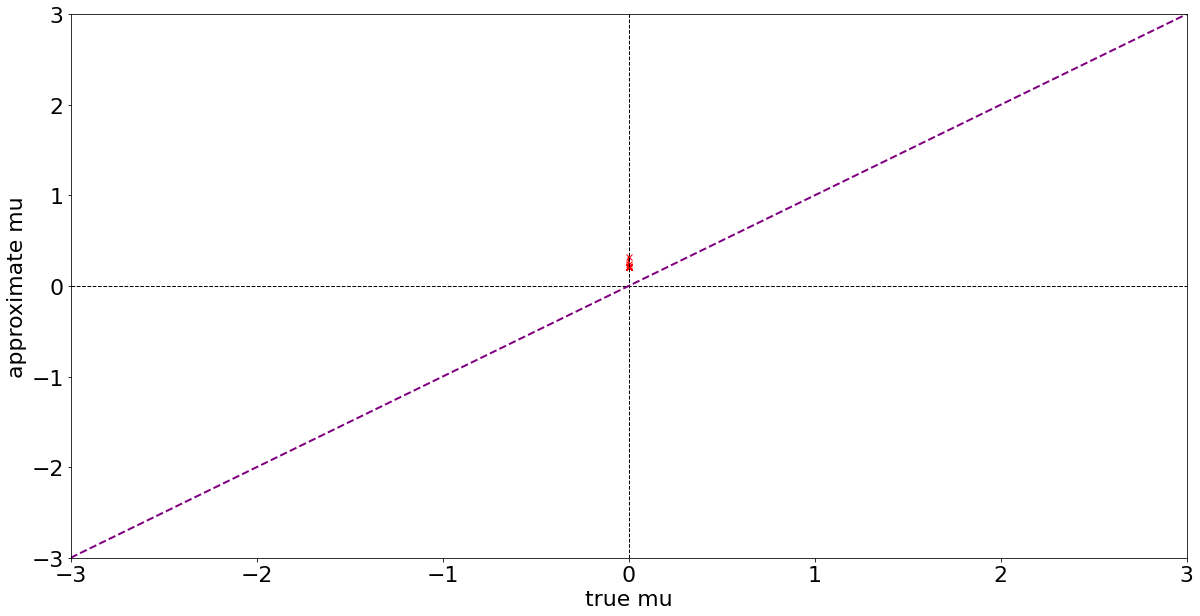

In [1224]:
vae.create_latent_plot()

In [634]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.

    - accepts stacks of means, but only one S0 and S1

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [637]:
m0 = np.array([1,2])
s0 = np.array([[1, -0.5], [-0.5, 1]])
m1 = np.array([1,2])
s1 = np.array([[1, 0], [0, 1]])

In [638]:
kl_mvn(m0, s0, m1, s1)

0.1438410362258904